In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
from shapely.geometry import box
import numpy as np

In [2]:
cd /home/op/network_manila

/home/op/network_manila


In [3]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [4]:
G_clip = nx.read_gpickle('data_osm_raw/manila_clean_clipped.pickle')

In [5]:
G_clip_disrupted = nx.read_gpickle('data_osm_raw/manila_clean_clipped_disrupted.pickle')

## prepare origin and destination points

In [6]:
#get administrative boundary of metro manila
philippines_adm2 = gpd.read_file("boundaries/philippines_adm2.geojson")
philippines_adm2 = philippines_adm2.to_crs({'init':'epsg:4326'})
manila = philippines_adm2[philippines_adm2.ADM2_NAME=="Metropolitan Manila"]

In [7]:
manila = manila.to_crs(crs_manila)

In [8]:
def create_point_grid(gdf, distance, crs):
    """
    this function creates a grid of points with equal distance within the space described by the geodataframe
    important: the crs passed as param has to be in accordance with the distance specified
    :param gdf: a geodataframe
    :param distance: distance between points. measured in crs of gdf
    :param crs: the crs in which the distance is measured to return the points
    :returns: a geodataframe of points
    """

    gdf_copy = gdf.copy()
    gdf_copy = gdf_copy.to_crs(crs)
    minx, miny, maxx, maxy = gdf_copy.bounds.values[0]
    poly = gdf_copy.unary_union
    x = minx
    points = []
    while x < maxx:
        y = miny
        while y < maxy:
            point = Point(x,y)
            #check whether point is within poly and keep only if this is the case
            if poly.intersects(point):
                points.append(point)
            y = y + distance
        x = x + distance
    df = pd.DataFrame({'geometry':points})  
    points_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)
    return points_gdf

In [9]:
box_geom = box(121.05, 14.6, 121.1, 14.65)
df = pd.DataFrame({"geometry":box_geom}, index=[0])
box_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs_global)

In [10]:
#clipped area only
origin_points = create_point_grid(box_gdf, distance = 500, crs = crs_manila)

In [11]:
origin_points = origin_points.to_crs(crs_global)
manila = manila.to_crs(crs_global)

In [12]:
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")
hospitals = hospitals[hospitals.intersects(box_gdf.unary_union)]

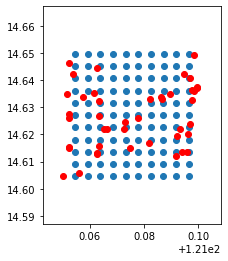

In [13]:
ax = origin_points.plot()
hospitals.plot(ax = ax, color='red')

## bind points to graph and calculate origin, destination matrices

In [14]:
origins_snapped = gn.pandana_snap(G_clip_disrupted, 
                                  origin_points, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1605: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1607: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [15]:
hospitals_snapped = gn.pandana_snap(G_clip_disrupted, 
                                  hospitals, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




In [16]:
origins_snapped

,geometry,NN,NN_dist
0,POINT (121.05463 14.60452),1260,66.064526
1,POINT (121.05463 14.60904),3620,6.694454
2,POINT (121.05463 14.61356),2684,46.264326
3,POINT (121.05463 14.61808),3850,48.801641
4,POINT (121.05464 14.62259),649,40.408544
...,...,...,...
105,POINT (121.09641 14.63162),1726,62.879071
106,POINT (121.09641 14.63614),4061,42.931384
107,POINT (121.09641 14.64066),207,14.378469
108,POINT (121.09642 14.64518),216,8.308062


In [2]:
def calculate_OD_with_startend(G, origins_gdf, destinations_gdf, walk_speed = (4.5/3.6),
                               fail_value = 999999999, weight_column = 'time', weighted_origins = False):
    """
    this function wraps around gn.calculate_OD and adds times to walk from the origin point to the first node
    and from the last node to the destination (off-network)    
    :param G: a graph object
    :param origins_gdf: the output of binding a list of origin points to G using gn.pandana_snap with
            parameter add_dist_to_node_col = True
    :param destinations_gdf: the output of binding a list of destination points to G using gn.pandana_snap
            with parameter add_dist_to_node_col = True
    :param walk_speed: a number, the speed at which to walk off-network. has to be in unit corrseponding to the
            Graphs "time" column used by gn.panadana_snap
    :param fail_value: a number, fail value passed to gn.calculate_OD
    :param weight_column: a string, weight_column passed to gn.calculate_OD
    :param weighted_origins: boolean, weighted_origins value passed to gn.calculate_OD

    :returns: a OD matrix (as numpy matrix) containing the distance from origin points (rows) to destination points (columns)
    """

    
    #convert origins and destinations to list of nodes
    origin_nodes = list(origins_gdf.NN)
    destination_nodes = list(destinations_gdf.NN)
    
    #calculate OD matrix between start and end nodes, in unit of "time"
    OD = gn.calculate_OD(G, origins= origin_nodes, destinations = destination_nodes, 
                         fail_value = fail_value, weight = weight_column, 
                         weighted_origins = weighted_origins)

    ## add time to walk from origin point to nearest node
    distance_to_node = np.asarray(origins_gdf.NN_dist)[:, np.newaxis]
    time_to_node = distance_to_node * walk_speed
    #each row of OD matrix is from same origin, so we can just use numpy's broadcasting
    OD = OD + time_to_node
    
    ## add time to walk from destination node to POI
    distance_from_node = np.asarray(destinations_gdf.NN_dist)[:, np.newaxis]
    time_from_node = distance_from_node * walk_speed
    #each column of OD matrix is same destination, so we transpose times and then add using numpy's broadcasting
    OD = OD + time_from_node.T
    
    return OD


In [18]:
OD = calculate_OD_with_startend(G_clip_disrupted, origins_snapped, hospitals_snapped, 
                                walk_speed = 4.5/3.6, fail_value = 999999999, weight_column = 'time', 
                                weighted_origins = False)


In [19]:
OD_disrupted = calculate_OD_with_startend(G_clip_disrupted, origins_snapped, hospitals_snapped, 
                                walk_speed = 4.5/3.6, fail_value = 999999999, weight_column = 'time_disrupted', 
                                weighted_origins = False)


In [20]:
OD.shape , OD_disrupted.shape

((110, 43), (110, 43))

In [68]:
min_distance = np.min(OD, axis = 1)
min_distance_disrupted = np.min(OD_disrupted, axis = 1)

origin_points['min_hospital_distance_seconds'] = min_distance
origin_points['min_hospital_distance_seconds_disrupted'] = min_distance_disrupted

#replace fail values with NAN
origin_points.loc[origin_points['min_hospital_distance_seconds_disrupted'] > 99999999, 
                  'min_hospital_distance_seconds_disrupted'] = np.NaN

In [69]:
origin_points_nonan = origin_points[origin_points.min_hospital_distance_seconds_disrupted.notnull()]
origin_points_nonan["increase_sec"] = (origin_points_nonan['min_hospital_distance_seconds_disrupted'] - 
                                 origin_points_nonan['min_hospital_distance_seconds'])
origin_points_nonan["increase_perc"] = ((origin_points_nonan['min_hospital_distance_seconds_disrupted'] - 
                                   origin_points_nonan['min_hospital_distance_seconds'])/
                                  origin_points_nonan['min_hospital_distance_seconds'])

origin_points_nonan.head()

/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,geometry,min_hospital_distance_seconds,min_hospital_distance_seconds_disrupted,increase_sec,increase_perc
0,POINT (121.05463 14.60452),128.952581,128.952581,0.0,0.0
1,POINT (121.05463 14.60904),148.339154,148.339154,0.0,0.0
2,POINT (121.05463 14.61356),163.473741,163.473741,0.0,0.0
3,POINT (121.05463 14.61808),168.717724,168.717724,0.0,0.0
4,POINT (121.05464 14.62259),151.636129,151.636129,0.0,0.0


## visualize results

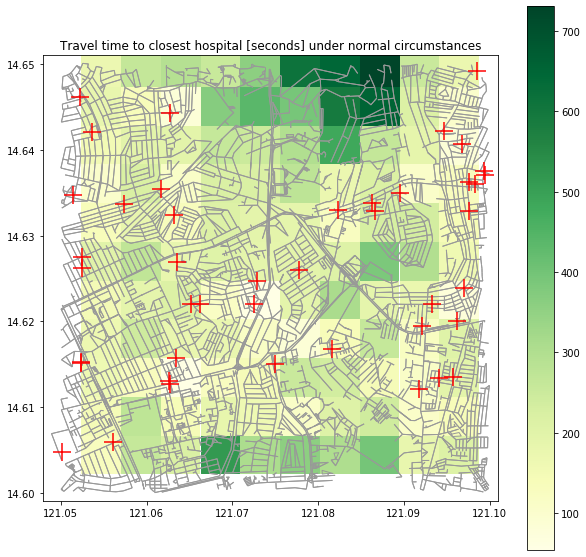

<Figure size 432x288 with 0 Axes>

In [67]:
G_clip_disrupted.graph.update( {'crs' : crs_global} )
G_clip_disrupted.graph.update( {'name' : 'manila'} )
fig, ax = ox.plot_graph(G_clip_disrupted, fig_height=10, axis_off=False, show=False, node_color="None" )
origin_points.plot(ax=ax, cmap="YlGn", column="min_hospital_distance_seconds", 
                   marker = "s", markersize=1500, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="red", marker="+", markersize=300, zorder=2)
ax.title.set_text("Travel time to closest hospital [seconds] under normal circumstances")
fig

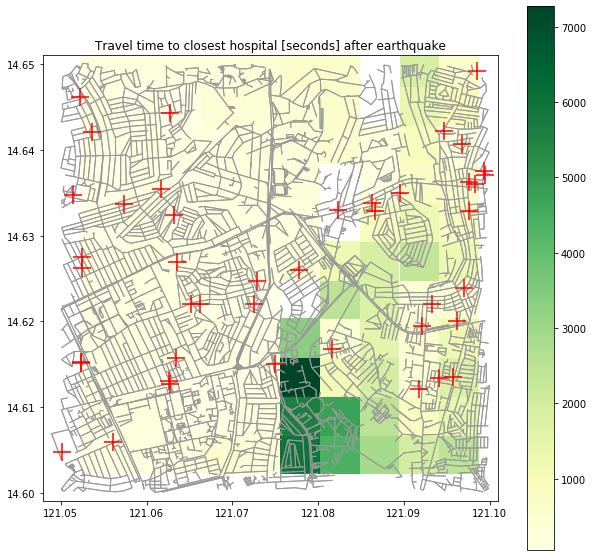

<Figure size 432x288 with 0 Axes>

In [65]:
G_clip_disrupted.graph.update( {'crs' : crs_global} )
G_clip_disrupted.graph.update( {'name' : 'manila'} )
fig1, ax = ox.plot_graph(G_clip_disrupted, fig_height=10, axis_off=False, show=False, node_color="None" )
origin_points.plot(ax=ax, cmap="YlGn", column="min_hospital_distance_seconds_disrupted", 
                   marker = "s", markersize=1500, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="red", marker="+", markersize=300, zorder=2)
ax.title.set_text("Travel time to closest hospital [seconds] after earthquake")

fig1

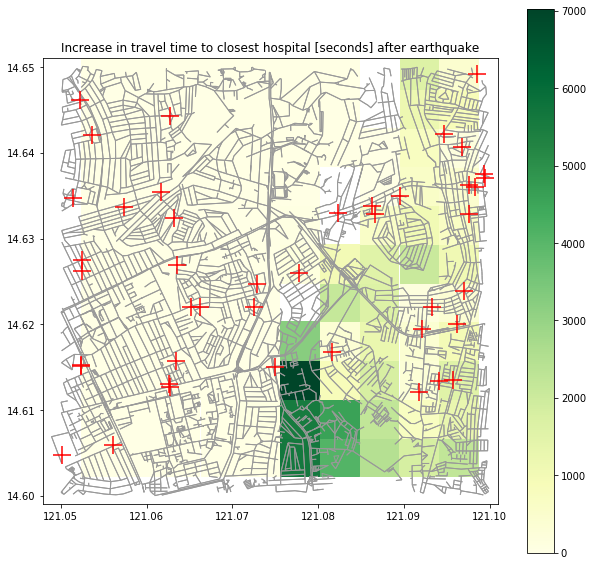

<Figure size 432x288 with 0 Axes>

In [72]:
G_clip_disrupted.graph.update( {'crs' : crs_global} )
G_clip_disrupted.graph.update( {'name' : 'manila'} )
fig1, ax = ox.plot_graph(G_clip_disrupted, fig_height=10, axis_off=False, show=False, node_color="None" )
origin_points_nonan.plot(ax=ax, cmap="YlGn", column="increase_sec", 
                   marker = "s", markersize=1500, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="red", marker="+", markersize=300, zorder=2)
ax.title.set_text("Increase in travel time to closest hospital [seconds] after earthquake")

fig1

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt 

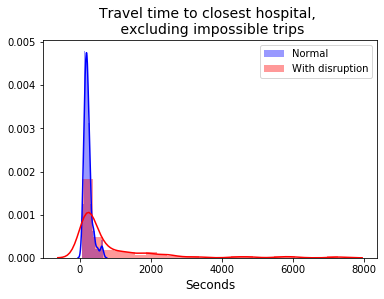

In [49]:
sns.distplot( origin_points_nonan["min_hospital_distance_seconds"] , color="blue", 
             label="Normal")
sns.distplot( origin_points_nonan["min_hospital_distance_seconds_disrupted"] , color="red", 
             label="With disruption")
plt.legend()
plt.title("Travel time to closest hospital, \n excluding impossible trips", fontsize = 14)
plt.xlabel("Seconds", fontsize = 12)
plt.show()

In [58]:
cut_off = len(origin_points) - origin_points.min_hospital_distance_seconds_disrupted.notnull().sum()
cut_off_perc = round(cut_off/len(origin_points)*100, 2)

av_trip_time = round(origin_points_nonan.min_hospital_distance_seconds.mean(), 2)
av_trip_time_disrupt = round(origin_points_nonan.min_hospital_distance_seconds_disrupted.mean(), 2)

av_increase_sec = round(origin_points_nonan.increase_sec.mean(), 2)
av_increase_perc = round(origin_points_nonan.increase_perc.mean()*100, 2)


print("Origin nodes that are completeley cut-off:", cut_off, "or", cut_off_perc, "percent of all origin nodes")
print("")
print("Average trip time for none-cut-off nodes :", av_trip_time, "seconds")
print("Average trip time for none-cut-off nodes with disruption:", av_trip_time_disrupt, "seconds")
print("")
print("Average increase for none-cut-off nodes:", av_increase_sec, "seconds", "or", av_increase_perc, "percent")

    

Origin nodes that are completeley cut-off: 5 or 4.55 percent of all origin nodes

Average trip time for none-cut-off nodes : 218.53 seconds
Average trip time for none-cut-off nodes with disruption: 863.26 seconds

Average increase for none-cut-off nodes: 644.73 seconds or 337.8 percent


### -> results are majorly determined by choice of liqeufaction speed